In [1]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
%matplotlib inline

## Constants

In [2]:
R = 8.314

Cp_m = 68
Cp_e = 90
Cp_b = 201
Cp_t = 249
Cp_sty = 273
Cp_eb = 299
Cp_h = 30
Cp_st = 40

ρ = 2137
ϕ = 0.4
ρ_bed = ρ*(1-ϕ)

ΔHrx1_298 = 118000
ΔHrx2_298 = 105200
ΔHrx3_298 = -53900

b1 = -17.34
b2 = -1.302e4
b3 = 5.051
b4 = -2.314e-10
b5 = 1.302e-6
b6 = -4.931e-3

nu_eb_1 = -1
nu_sty_1 = 1
nu_h_1 = 1

nu_eb_2 = -1
nu_b_2 = 1
nu_e_2 = 1

nu_eb_3 = -1
nu_h_3 = -1
nu_t_3 = 1
nu_m_3 = 1

ΔCprx1 = (-1)*Cp_eb + (1)*Cp_sty + (1)*Cp_h
ΔCprx2 = (-1)*Cp_eb + (1)*Cp_b + (1)*Cp_e
ΔCprx3 = (-1)*Cp_eb + (-1)*Cp_h + (1)*Cp_t + (1)*Cp_m

Tref = 298

V_PFR = 10

dp = 1/1000

# viscosities of pure components
μ_eb = 2.72/1000    # Pa.s
μ_sty = 0.05        # Pa.s
μ_m = 1.05e-5       # Pa.s
μ_t = 0.3/1000      # Pa.s
μ_b = 5.04e-5       # Pa.s
μ_h = 1.84e-5       # Pa.s
μ_e = 0.01377/1000  # Pa.s
μ_st = 0.03/1000    # Pa.s

# densities of pure components
M_eb = 106.167
M_sty = 104.15
M_m = 16.04
M_t = 92.14
M_b = 78.11
M_h = 1.00784
M_e = 28.05
M_st = 18.015

ho = 1200 # W/m2.K
Rfi = 0.0001   # m2.K/W
Rfo = 0.0004   # m2.K/W
k = 24       # W/m.K

Pr = 0.87
n_Nusselt = 0.4

## Inlet Conditions

In [3]:
To = 939
steam_ratio = 27.3

F_eb_o = 0.00344
F_sty_o = 0
F_t_o = 0
F_b_o = 0
F_m_o = 0
F_e_o = 0
F_h_o = 0
F_st_o = F_eb_o*steam_ratio

F_tot_inlet = F_eb_o + F_st_o
x_st_inlet = F_st_o/F_tot_inlet
x_eb_inlet = F_eb_o/F_tot_inlet

MM_avg_inlet = x_st_inlet*M_st + x_eb_inlet*M_eb

Po = 2.4

Q_inlet = F_tot_inlet*R*To/(Po*101.325)
print(f'Q_inlet = {Q_inlet} m3/s')

ρ_inlet = Po*101.325*MM_avg_inlet/R/To
print(f'ρ_inlet = {ρ_inlet} kg/m3')

μ_inlet = x_st_inlet*μ_st + x_eb_inlet*μ_eb
print(f'μ_inlet = {μ_inlet} Pa.s')


Q_inlet = 3.125306652652356 m3/s
ρ_inlet = 0.658187943974794 kg/m3
μ_inlet = 0.00012505300353356891 Pa.s


## PFR function

In [4]:
def PFR_non_adiabatic(V, var):
    F_eb, F_sty, F_t, F_b, F_m, F_e, F_h, T, P = var
    Tu = 1000
    #Ua = 100/60          # kJ/m3.s.K
    F_tot = F_eb + F_sty + F_st + F_t + F_b + F_m + F_e + F_h

    # partial pressures
    p_eb  = F_eb/F_tot*P
    p_sty = F_sty/F_tot*P
    #p_st  = F_st/F_tot*P
    p_t   = F_t/F_tot*P
    p_b   = F_b/F_tot*P
    p_m   = F_m/F_tot*P
    p_e   = F_e/F_tot*P
    p_h   = F_h/F_tot*P
    
    Kp = np.exp(b1 + b2/T + b3*np.log(T) + ((b4*T + b5)*T + b6)*T)
    
    # reaction 1
    k1_m = np.exp(-0.08539-10925/T)
    r_sty_1 = ρ_bed*k1_m*(p_eb - p_sty*p_h/Kp)       # kmol/m3.s
    r_h_1 = r_sty_1
    r_eb_1 = -r_sty_1
    
    # reaction 2
    k2_m = np.exp(13.2392-25000/T)
    r_b_2 = ρ_bed*k2_m*p_eb                       # kmol/m3.s
    r_e_2 = r_b_2
    r_eb_2 = -r_b_2
    
    # reaction 3
    k3_m = np.exp(0.2961-11000/T)
    r_t_3 = ρ_bed*k3_m*p_eb*p_h                    # kmol/m3.s
    r_m_3 = r_t_3
    r_h_3 = -r_t_3
    r_eb_3 = -r_t_3
    
    # reaction rates summed together
    r_eb = r_eb_1 + r_eb_2 + r_eb_3
    r_sty = r_sty_1
    r_h = r_h_1 + r_h_3
    r_b = r_b_2
    r_e = r_e_2
    r_t = r_t_3
    r_m = r_m_3
    
    # mole balances (DE's)
    dFebdV = r_eb
    dFstydV = r_sty
    dFtdV = r_t
    dFbdV = r_b
    dFmdV = r_m
    dFedV = r_e
    dFhdV = r_h
    
    # energy carrying capacity - must include the inert steam!
    ECC = F_eb*Cp_eb + F_sty*Cp_sty + F_st*Cp_st + F_t*Cp_t + F_b*Cp_b + F_m*Cp_m + F_e*Cp_e + F_h*Cp_h
    
    # Heats of reactions at every T
    ΔHrx1_T = ΔHrx1_298 + ΔCprx1*(T-Tref)
    ΔHrx2_T = ΔHrx2_298 + ΔCprx2*(T-Tref)
    ΔHrx3_T = ΔHrx3_298 + ΔCprx3*(T-Tref)
        
    # Heating up to unknown T (2nd step) - done i.t.o ethylbenzene (eb)
    ΔHfs_2_rxn1 = r_eb_1*ΔHrx1_T/(-1)
    ΔHfs_2_rxn2 = r_eb_2*ΔHrx2_T/(-1)
    ΔHfs_2_rxn3 = r_eb_3*ΔHrx3_T/(-1)
    ΔHfs_2 = ΔHfs_2_rxn1 + ΔHfs_2_rxn2 + ΔHfs_2_rxn3
   
    # energy balance
    Q = Ua*(Tu-T)
    dTdV = (Q-ΔHfs_2)/ECC
    
    # pressure drop
    dPdV = 0
    
    return dFebdV, dFstydV, dFtdV, dFbdV, dFmdV, dFedV, dFhdV, dTdV, dPdV

Di = 35.6/1000
Ai = np.pi/4*Di**2
u_inlet = Q_inlet/Ai
Re = Di*u_inlet*ρ_inlet/μ_inlet#/(1-ϕ)
print(Re)

588313.146141523


## Nested for loop - iterating through tube diameter and tube thickness

C:\Anaconda\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in double_scalars
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: overflow encountered in double_scalars
C:\Anaconda\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in double_scalars


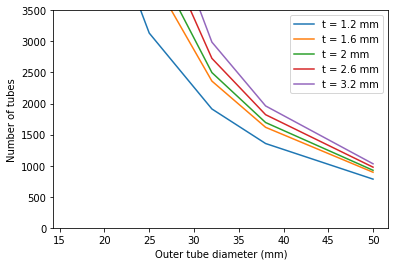

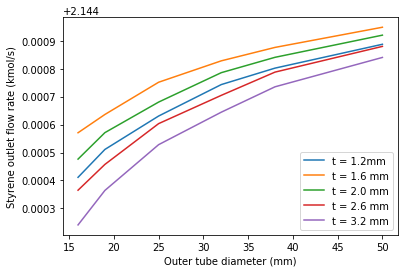

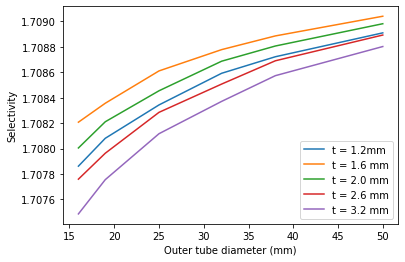

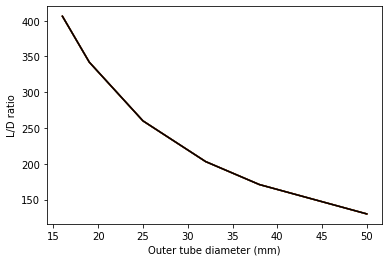

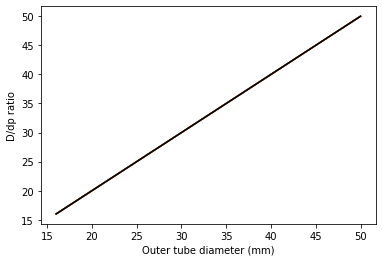

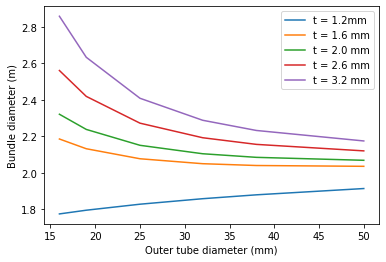

In [5]:
tube_Diameter = np.array([0.016, 0.019, 0.025, 0.032, 0.038, 0.05])   # diameter of tubes in metres
tube_thickness = np.array([1.2/1000, 1.6/1000, 2/1000, 2.6/1000, 3.2/1000])

Ntubes_array_0 = []
Ntubes_array_1 = []
Ntubes_array_2 = []
Ntubes_array_3 = []
Ntubes_array_4 = []

U_array_0 = []
U_array_1 = []
U_array_2 = []
U_array_3 = []
U_array_4 = []

L_Do_ratio_0 = []
L_Do_ratio_1 = []
L_Do_ratio_2 = []
L_Do_ratio_3 = []
L_Do_ratio_4 = []

dp_dtube_array_0 = []
dp_dtube_array_1 = []
dp_dtube_array_2 = []
dp_dtube_array_3 = []
dp_dtube_array_4 = []

Db_0 = []
Db_1 = []
Db_2 = []
Db_3 = []
Db_4 = []

Ua_array_0 = []
Ua_array_1 = []
Ua_array_2 = []
Ua_array_3 = []
Ua_array_4 = []

selectivity_out_array_0 = []
selectivity_out_array_1 = []
selectivity_out_array_2 = []
selectivity_out_array_3 = []
selectivity_out_array_4 = []

sty_out_array_0 = []
sty_out_array_1 = []
sty_out_array_2 = []
sty_out_array_3 = []
sty_out_array_4 = []

Re_0_array_of_arrays = []
Re_1_array_of_arrays = []
Re_2_array_of_arrays = []
Re_3_array_of_arrays = []
Re_4_array_of_arrays = []

Pe_0_array_of_arrays = []
Pe_1_array_of_arrays = []
Pe_2_array_of_arrays = []
Pe_3_array_of_arrays = []
Pe_4_array_of_arrays = []

Disp_0_array_of_arrays = []
Disp_1_array_of_arrays = []
Disp_2_array_of_arrays = []
Disp_3_array_of_arrays = []
Disp_4_array_of_arrays = []

L = 6.5   # meters
V_PFR = 10
dp = 1/1000



for Do in tube_Diameter:
    for t in tube_thickness:
        
        if t == tube_thickness[0]:
            'Tube measurements'
            Di = Do-2*t
            Ai = np.pi/4*Di**2
            Ao = np.pi/4*Do**2
    
            'Volume'
            Vtube = L*Ao
    
            'No. of tubes'
            N = V_PFR/Vtube
            Ntubes_array_0.append(N)
            
            'Re and Pr and Nu'
            u_inlet = Q_inlet/Ai
            Re = Di*u_inlet*ρ_inlet/μ_inlet#/(1-ϕ)
            Nu = 0.023*Re**0.8*Pr**n_Nusselt
            
            'U constants calcs'
            hi = Nu*k/Di   # W/m2.K

    
            'U calcs'
            UiAi = 1/(1/hi/Ai + Rfi/Ai + np.log(Do/Di)/(2*np.pi*k*L) + Rfo/Ao + 1/ho/Ao)
            U = UiAi/Ai
            U_array_0.append(U)
            
            'L/D ratio'
            L_Dt = L/Do
            L_Do_ratio_0.append(L_Dt)
    
            'dp/dtube'
            dp_dtube = Do/dp
            dp_dtube_array_0.append(dp_dtube)
    
            'steam ratio per tube'
            F_st = F_eb_o*23.93/N
    
            'bundle diameter (for triangular pitch)'
            K1 = 0.319
            n1 = 2.142
            Db = Do*1000*(N/K1)**(1/n1)/1000     # metres
            Db_0.append(Db)
    
            'a value'
            a = 4/Db
            Ua = U*a
            Ua_array_0.append(Ua)
            
            'PFR function'
            init_non_adiabatic = [F_eb_o/N, F_sty_o, F_t_o, F_b_o, F_m_o, F_e_o, F_h_o, To, Po]
            Vrange = (0, V_PFR/N)
            Vspan = np.linspace(0,V_PFR/N, 10)
            ans_non_adiabatic = solve_ivp(PFR_non_adiabatic, Vrange, init_non_adiabatic, dense_output=True)
            F_eb, F_sty, F_t, F_b, F_m, F_e, F_h, T, P = ans_non_adiabatic.sol(Vspan)
            
            'Outlet flow rates'
            F_sty_final = F_sty[-1]*N*1000
            F_b_final = F_b[-1]*N*1000
            F_t_final = F_t[-1]*N*1000
    
            'Selectivity'
            selectivity = F_sty_final/(F_b_final+F_t_final) 
            selectivity_out_array_0.append(selectivity)
            
            'Styrene out'
            sty_out_array_0.append(F_sty_final)
            
            'mole fractions'
            n = F_eb + F_sty + F_t + F_b + F_m + F_e + F_h + F_st
            x_eb = F_eb/n
            x_sty = F_sty/n
            x_t = F_t/n
            x_b = F_b/n
            x_m = F_e/n
            x_e = F_e/n
            x_h = F_h/n
            x_st = F_st/n
            
            'partial pressures'
            P = P*101.325
            p_eb = x_eb*P
            p_sty = x_sty*P
            p_t = x_t*P
            p_b = x_b*P
            p_m = x_m*P
            p_e = x_e*P
            p_h = x_h*P
            p_st = x_st*P
            
            'Superficial fluid velocity'
            Q = n*R*T/P
            u = Q/Ai
            
            
            'Viscosity'
            μ = μ_eb*x_eb + μ_sty*x_sty + μ_t*x_t + μ_b*x_b + μ_m*x_m + μ_e*x_e + μ_h*x_h + μ_st*x_st
            
            'Density'
            ρ_eb = p_eb*M_eb/R/T
            ρ_sty = p_sty*M_sty/R/T
            ρ_t =  p_t*M_t/R/T
            ρ_b =  p_b*M_b/R/T
            ρ_m =  p_m*M_m/R/T
            ρ_e =  p_e*M_e/R/T
            ρ_h =  p_h*M_h/R/T
            ρ_st =  p_st*M_st/R/T
            ρ =  1/(x_eb/ρ_eb + x_sty*ρ_sty + x_t*ρ_t + x_b*ρ_b + x_m*ρ_m + x_e*ρ_e + x_h*ρ_h + x_st*ρ_st)
            
            'Reynolds number'
            Re_0 = dp*u*ρ/μ/(1-ϕ)
            Re_0_array_of_arrays.append(Re_0)

            'Dispersion coefficient'
            Disp = 0.6*dp*u/ϕ
            Disp_0_array_of_arrays.append(Disp)
            
            'Peclet'
            Pe = L/(u*Disp)
            Pe_0_array_of_arrays.append(Pe)

    
            
            ###########################################################################################################
            
        if t == tube_thickness[1]:
            'Tube measurements'
            Di = Do-2*t
            Ai = np.pi/4*Di**2
            Ao = np.pi/4*Do**2
    
            'Volume'
            Vtube = L*Ai
    
            'No. of tubes'
            N = V_PFR/Vtube
            Ntubes_array_1.append(N)   
            
            'Re and Pr and Nu'
            u_inlet = Q_inlet/Ai
            Re = Di*u_inlet*ρ_inlet/μ_inlet#/(1-ϕ)
            Nu = 0.023*Re**0.8*Pr**n_Nusselt
            
            'U constants calcs'
            hi = Nu*k/Di   # W/m2.K
    
            'U calcs'
            UiAi = 1/(1/hi/Ai + Rfi/Ai + np.log(Do/Di)/(2*np.pi*L) + Rfo/Ao + 1/ho/Ao)
            U = UiAi/Ai
            U_array_1.append(U)
            
            'L/D ratio'
            L_Dt = L/Do
            L_Do_ratio_1.append(L_Dt)
    
            'dp/dtube'
            dp_dtube = Do/dp
            dp_dtube_array_1.append(dp_dtube)
    
            'steam ratio per tube'
            F_st = F_eb_o*23.93/N
    
            'bundle diameter (for triangular pitch)'
            K1 = 0.319
            n1 = 2.142
            Db = Do*1000*(N/K1)**(1/n1)/1000     # metres
            Db_1.append(Db)
    
            'a value'
            a = 4/Db
            Ua = U*a
            Ua_array_1.append(Ua) 
            
            'PFR function'
            init_non_adiabatic = [F_eb_o/N, F_sty_o, F_t_o, F_b_o, F_m_o, F_e_o, F_h_o, To, Po]
            Vrange = (0, V_PFR/N)
            Vspan = np.linspace(0,V_PFR/N, 10)
            ans_non_adiabatic = solve_ivp(PFR_non_adiabatic, Vrange, init_non_adiabatic, dense_output=True)
            F_eb, F_sty, F_t, F_b, F_m, F_e, F_h, T, P = ans_non_adiabatic.sol(Vspan)
    
            'Outlet flow rates'
            F_sty_final = F_sty[-1]*N*1000
            F_b_final = F_b[-1]*N*1000
            F_t_final = F_t[-1]*N*1000
    
            'Selectivity'
            selectivity = F_sty_final/(F_b_final+F_t_final) 
            selectivity_out_array_1.append(selectivity)
            
            'Styrene out'
            sty_out_array_1.append(F_sty_final)
            
            'mole fractions'
            n = F_eb + F_sty + F_t + F_b + F_m + F_e + F_h + F_st
            x_eb = F_eb/n
            x_sty = F_sty/n
            x_t = F_t/n
            x_b = F_b/n
            x_m = F_e/n
            x_e = F_e/n
            x_h = F_h/n
            x_st = F_st/n
            
            'partial pressures'
            p_eb = x_eb*P
            p_sty = x_sty*P
            p_t = x_t*P
            p_b = x_b*P
            p_m = x_m*P
            p_e = x_e*P
            p_h = x_h*P
            p_st = x_st*P
            
            'Superficial fluid velocity'
            Q = n*R*T/P
            u = Q/Ai
            
            'Viscosity'
            μ = μ_eb*x_eb + μ_sty*x_sty + μ_t*x_t + μ_b*x_b + μ_m*x_m + μ_e*x_e + μ_h*x_h + μ_st*x_st
            
            'Density'
            ρ_eb = p_eb*M_eb/R/T
            ρ_sty = p_sty*M_sty/R/T
            ρ_t =  p_t*M_t/R/T
            ρ_b =  p_b*M_b/R/T
            ρ_m =  p_m*M_m/R/T
            ρ_e =  p_e*M_e/R/T
            ρ_h =  p_h*M_h/R/T
            ρ_st =  p_st*M_st/R/T
            ρ =  1/(x_eb/ρ_eb + x_sty*ρ_sty + x_t*ρ_t + x_b*ρ_b + x_m*ρ_m + x_e*ρ_e + x_h*ρ_h + x_st*ρ_st)
            
            'Reynolds number'
            Re_1 = dp*u*ρ/μ/(1-ϕ)
            Re_1_array_of_arrays.append(Re_1)      
            
            ###########################################################################################################

        if t == tube_thickness[2]:
            'Tube measurements'
            Di = Do-2*t
            Ai = np.pi/4*Di**2
            Ao = np.pi/4*Do**2
    
            'Volume'
            Vtube = L*Ai
    
            'No. of tubes'
            N = V_PFR/Vtube
            Ntubes_array_2.append(N)   
            
            'Re and Pr and Nu'
            u_inlet = Q_inlet/Ai
            Re = Di*u_inlet*ρ_inlet/μ_inlet#/(1-ϕ)
            Nu = 0.023*Re**0.8*Pr**n_Nusselt
            
            'U constants calcs'
            hi = Nu*k/Di   # W/m2.K
    
            'U calcs'
            UiAi = 1/(1/hi/Ai + Rfi/Ai + np.log(Do/Di)/(2*np.pi*L) + Rfo/Ao + 1/ho/Ao)
            U = UiAi/Ai
            U_array_2.append(U)
            
            'L/D ratio'
            L_Dt = L/Do
            L_Do_ratio_2.append(L_Dt)
    
            'dp/dtube'
            dp_dtube = Do/dp
            dp_dtube_array_2.append(dp_dtube)
    
            'steam ratio per tube'
            F_st = F_eb_o*23.93/N
    
            'bundle diameter (for triangular pitch)'
            K1 = 0.319
            n1 = 2.142
            Db = Do*1000*(N/K1)**(1/n1)/1000     # metres
            Db_2.append(Db)
    
            'a value'
            a = 4/Db
            Ua = U*a
            Ua_array_2.append(Ua) 
            
            'PFR function'
            init_non_adiabatic = [F_eb_o/N, F_sty_o, F_t_o, F_b_o, F_m_o, F_e_o, F_h_o, To, Po]
            Vrange = (0, V_PFR/N)
            Vspan = np.linspace(0,V_PFR/N, 10)
            ans_non_adiabatic = solve_ivp(PFR_non_adiabatic, Vrange, init_non_adiabatic, dense_output=True)
            F_eb, F_sty, F_t, F_b, F_m, F_e, F_h, T, P = ans_non_adiabatic.sol(Vspan)
    
            'Outlet flow rates'
            F_sty_final = F_sty[-1]*N*1000
            F_b_final = F_b[-1]*N*1000
            F_t_final = F_t[-1]*N*1000
    
            'Selectivity'
            selectivity = F_sty_final/(F_b_final+F_t_final) 
            selectivity_out_array_2.append(selectivity)
            
            'Styrene out'
            sty_out_array_2.append(F_sty_final)
            
            'mole fractions'
            n = F_eb + F_sty + F_t + F_b + F_m + F_e + F_h + F_st
            x_eb = F_eb/n
            x_sty = F_sty/n
            x_t = F_t/n
            x_b = F_b/n
            x_m = F_e/n
            x_e = F_e/n
            x_h = F_h/n
            x_st = F_st/n
            
            'partial pressures'
            p_eb = x_eb*P
            p_sty = x_sty*P
            p_t = x_t*P
            p_b = x_b*P
            p_m = x_m*P
            p_e = x_e*P
            p_h = x_h*P
            p_st = x_st*P
            
            'Superficial fluid velocity'
            Q = n*R*T/P
            u = Q/Ai
            
            'Viscosity'
            μ = μ_eb*x_eb + μ_sty*x_sty + μ_t*x_t + μ_b*x_b + μ_m*x_m + μ_e*x_e + μ_h*x_h + μ_st*x_st
            
            'Density'
            ρ_eb = p_eb*M_eb/R/T
            ρ_sty = p_sty*M_sty/R/T
            ρ_t =  p_t*M_t/R/T
            ρ_b =  p_b*M_b/R/T
            ρ_m =  p_m*M_m/R/T
            ρ_e =  p_e*M_e/R/T
            ρ_h =  p_h*M_h/R/T
            ρ_st =  p_st*M_st/R/T
            ρ =  1/(x_eb/ρ_eb + x_sty*ρ_sty + x_t*ρ_t + x_b*ρ_b + x_m*ρ_m + x_e*ρ_e + x_h*ρ_h + x_st*ρ_st)
            
            'Reynolds number'
            Re_2 = dp*u*ρ/μ/(1-ϕ)
            Re_2_array_of_arrays.append(Re_2)
            
            ###########################################################################################################
            
        if t == tube_thickness[3]:
            'Tube measurements'
            Di = Do-2*t
            Ai = np.pi/4*Di**2
            Ao = np.pi/4*Do**2
    
            'Volume'
            Vtube = L*Ai
    
            'No. of tubes'
            N = V_PFR/Vtube
            Ntubes_array_3.append(N)   
            
            'Re and Pr and Nu'
            u_inlet = Q_inlet/Ai
            Re = Di*u_inlet*ρ_inlet/μ_inlet#/(1-ϕ)
            Nu = 0.023*Re**0.8*Pr**n_Nusselt
            
            'U constants calcs'
            hi = Nu*k/Di   # W/m2.K
    
            'U calcs'
            UiAi = 1/(1/hi/Ai + Rfi/Ai + np.log(Do/Di)/(2*np.pi*L) + Rfo/Ao + 1/ho/Ao)
            U = UiAi/Ai
            U_array_3.append(U)
            
            'L/D ratio'
            L_Dt = L/Do
            L_Do_ratio_3.append(L_Dt)
    
            'dp/dtube'
            dp_dtube = Do/dp
            dp_dtube_array_3.append(dp_dtube)
    
            'steam ratio per tube'
            F_st = F_eb_o*23.93/N
    
            'bundle diameter (for triangular pitch)'
            K1 = 0.319
            n1 = 2.142
            Db = Do*1000*(N/K1)**(1/n1)/1000     # metres
            Db_3.append(Db)
    
            'a value'
            a = 4/Db
            Ua = U*a
            Ua_array_3.append(Ua) 
            
            'PFR function'
            init_non_adiabatic = [F_eb_o/N, F_sty_o, F_t_o, F_b_o, F_m_o, F_e_o, F_h_o, To, Po]
            Vrange = (0, V_PFR/N)
            Vspan = np.linspace(0,V_PFR/N, 10)
            ans_non_adiabatic = solve_ivp(PFR_non_adiabatic, Vrange, init_non_adiabatic, dense_output=True)
            F_eb, F_sty, F_t, F_b, F_m, F_e, F_h, T, P = ans_non_adiabatic.sol(Vspan)
    
            'Outlet flow rates'
            F_sty_final = F_sty[-1]*N*1000
            F_b_final = F_b[-1]*N*1000
            F_t_final = F_t[-1]*N*1000
    
            'Selectivity'
            selectivity = F_sty_final/(F_b_final+F_t_final) 
            selectivity_out_array_3.append(selectivity)
            
            'Styrene out'
            sty_out_array_3.append(F_sty_final)
            
            'mole fractions'
            n = F_eb + F_sty + F_t + F_b + F_m + F_e + F_h + F_st
            x_eb = F_eb/n
            x_sty = F_sty/n
            x_t = F_t/n
            x_b = F_b/n
            x_m = F_e/n
            x_e = F_e/n
            x_h = F_h/n
            x_st = F_st/n
            
            'partial pressures'
            p_eb = x_eb*P
            p_sty = x_sty*P
            p_t = x_t*P
            p_b = x_b*P
            p_m = x_m*P
            p_e = x_e*P
            p_h = x_h*P
            p_st = x_st*P
            
            'Superficial fluid velocity'
            Q = n*R*T/P
            u = Q/Ai
            
            'Viscosity'
            μ = μ_eb*x_eb + μ_sty*x_sty + μ_t*x_t + μ_b*x_b + μ_m*x_m + μ_e*x_e + μ_h*x_h + μ_st*x_st
            
            'Density'
            ρ_eb = p_eb*M_eb/R/T
            ρ_sty = p_sty*M_sty/R/T
            ρ_t =  p_t*M_t/R/T
            ρ_b =  p_b*M_b/R/T
            ρ_m =  p_m*M_m/R/T
            ρ_e =  p_e*M_e/R/T
            ρ_h =  p_h*M_h/R/T
            ρ_st =  p_st*M_st/R/T
            ρ =  1/(x_eb/ρ_eb + x_sty*ρ_sty + x_t*ρ_t + x_b*ρ_b + x_m*ρ_m + x_e*ρ_e + x_h*ρ_h + x_st*ρ_st)
            
            'Reynolds number'
            Re_3 = dp*u*ρ/μ/(1-ϕ)
            Re_3_array_of_arrays.append(Re_3)
            
            ###########################################################################################################
            
        if t == tube_thickness[4]:
            'Tube measurements'
            Di = Do-2*t
            Ai = np.pi/4*Di**2
            Ao = np.pi/4*Do**2
    
            'Volume'
            Vtube = L*Ai
    
            'No. of tubes'
            N = V_PFR/Vtube
            Ntubes_array_4.append(N)   
            
            'Re and Pr and Nu'
            u_inlet = Q_inlet/Ai
            Re = Di*u_inlet*ρ_inlet/μ_inlet#/(1-ϕ)
            Nu = 0.023*Re**0.8*Pr**n_Nusselt
            
            'U constants calcs'
            hi = Nu*k/Di   # W/m2.K
    
            'U calcs'
            UiAi = 1/(1/hi/Ai + Rfi/Ai + np.log(Do/Di)/(2*np.pi*L) + Rfo/Ao + 1/ho/Ao)
            U = UiAi/Ai
            U_array_4.append(U)
            
            'L/D ratio'
            L_Dt = L/Do
            L_Do_ratio_4.append(L_Dt)
    
            'dp/dtube'
            dp_dtube = Do/dp
            dp_dtube_array_4.append(dp_dtube)
    
            'steam ratio per tube'
            F_st = F_eb_o*23.93/N
    
            'bundle diameter (for triangular pitch)'
            K1 = 0.319
            n1 = 2.142
            Db = Do*1000*(N/K1)**(1/n1)/1000     # metres
            Db_4.append(Db)
    
            'a value'
            a = 4/Db
            Ua = U*a
            Ua_array_4.append(Ua)

            
            'PFR function'
            init_non_adiabatic = [F_eb_o/N, F_sty_o, F_t_o, F_b_o, F_m_o, F_e_o, F_h_o, To, Po]
            Vrange = (0, V_PFR/N)
            Vspan = np.linspace(0,V_PFR/N, 10)
            ans_non_adiabatic = solve_ivp(PFR_non_adiabatic, Vrange, init_non_adiabatic, dense_output=True)
            F_eb, F_sty, F_t, F_b, F_m, F_e, F_h, T, P = ans_non_adiabatic.sol(Vspan)
    
            'Outlet flow rates'
            F_sty_final = F_sty[-1]*N*1000
            F_b_final = F_b[-1]*N*1000
            F_t_final = F_t[-1]*N*1000
    
            'Selectivity'
            selectivity = F_sty_final/(F_b_final+F_t_final) 
            selectivity_out_array_4.append(selectivity)
            
            'Styrene out'
            sty_out_array_4.append(F_sty_final)
            
            'mole fractions'
            n = F_eb + F_sty + F_t + F_b + F_m + F_e + F_h + F_st
            x_eb = F_eb/n
            x_sty = F_sty/n
            x_t = F_t/n
            x_b = F_b/n
            x_m = F_e/n
            x_e = F_e/n
            x_h = F_h/n
            x_st = F_st/n
            
            'partial pressures'
            p_eb = x_eb*P
            p_sty = x_sty*P
            p_t = x_t*P
            p_b = x_b*P
            p_m = x_m*P
            p_e = x_e*P
            p_h = x_h*P
            p_st = x_st*P
            
            'Superficial fluid velocity'
            Q = n*R*T/P
            u = Q/Ai
            
            'Viscosity'
            μ = μ_eb*x_eb + μ_sty*x_sty + μ_t*x_t + μ_b*x_b + μ_m*x_m + μ_e*x_e + μ_h*x_h + μ_st*x_st
            
            'Density'
            ρ_eb = p_eb*M_eb/R/T
            ρ_sty = p_sty*M_sty/R/T
            ρ_t =  p_t*M_t/R/T
            ρ_b =  p_b*M_b/R/T
            ρ_m =  p_m*M_m/R/T
            ρ_e =  p_e*M_e/R/T
            ρ_h =  p_h*M_h/R/T
            ρ_st =  p_st*M_st/R/T
            ρ =  1/(x_eb/ρ_eb + x_sty*ρ_sty + x_t*ρ_t + x_b*ρ_b + x_m*ρ_m + x_e*ρ_e + x_h*ρ_h + x_st*ρ_st)
            
            'Reynolds number'
            Re_4 = dp*u*ρ/μ/(1-ϕ)
            Re_4_array_of_arrays.append(Re_4)


plt.plot(tube_Diameter*1000, Ntubes_array_0)
plt.plot(tube_Diameter*1000, Ntubes_array_1)
plt.plot(tube_Diameter*1000, Ntubes_array_2)
plt.plot(tube_Diameter*1000, Ntubes_array_3)
plt.plot(tube_Diameter*1000, Ntubes_array_4)
plt.xlabel('Outer tube diameter (mm)')
plt.ylabel('Number of tubes')
plt.ylim(0,3500)
plt.legend(['t = 1.2 mm', 't = 1.6 mm', 't = 2 mm', 't = 2.6 mm', 't = 3.2 mm'])
#plt.ylim(0,1000)
plt.show()


plt.plot(tube_Diameter*1000, sty_out_array_0)
plt.plot(tube_Diameter*1000, sty_out_array_1)
plt.plot(tube_Diameter*1000, sty_out_array_2)
plt.plot(tube_Diameter*1000, sty_out_array_3)
plt.plot(tube_Diameter*1000, sty_out_array_4)
plt.xlabel('Outer tube diameter (mm)')
plt.ylabel('Styrene outlet flow rate (kmol/s)')
plt.legend(['t = 1.2mm', 't = 1.6 mm', 't = 2.0 mm', 't = 2.6 mm', 't = 3.2 mm'])
plt.show()

plt.plot(tube_Diameter*1000, selectivity_out_array_0)
plt.plot(tube_Diameter*1000, selectivity_out_array_1)
plt.plot(tube_Diameter*1000, selectivity_out_array_2)
plt.plot(tube_Diameter*1000, selectivity_out_array_3)
plt.plot(tube_Diameter*1000, selectivity_out_array_4)
plt.xlabel('Outer tube diameter (mm)')
plt.ylabel('Selectivity')
plt.legend(['t = 1.2mm', 't = 1.6 mm', 't = 2.0 mm', 't = 2.6 mm', 't = 3.2 mm'])
plt.show()

plt.plot(tube_Diameter*1000, L_Do_ratio_0)
plt.plot(tube_Diameter*1000, L_Do_ratio_1)
plt.plot(tube_Diameter*1000, L_Do_ratio_2)
plt.plot(tube_Diameter*1000, L_Do_ratio_3)
plt.plot(tube_Diameter*1000, L_Do_ratio_4, 'k')
plt.xlabel('Outer tube diameter (mm)')
plt.ylabel('L/D ratio')
#plt.legend(['t = 1.2mm', 't = 1.6 mm', 't = 2 mm', 't = 2.6 mm', 't = 3.2 mm'])
plt.show()

plt.plot(tube_Diameter*1000, dp_dtube_array_0)
plt.plot(tube_Diameter*1000, dp_dtube_array_1)
plt.plot(tube_Diameter*1000, dp_dtube_array_2)
plt.plot(tube_Diameter*1000, dp_dtube_array_3)
plt.plot(tube_Diameter*1000, dp_dtube_array_4, 'k')
plt.xlabel('Outer tube diameter (mm)')
plt.ylabel('D/dp ratio')
#plt.legend(['t = 1.2mm', 't = 1.6 mm', 't = 2.0 mm', 't = 2.6 mm', 't = 3.2 mm'])
plt.show()

plt.plot(tube_Diameter*1000, Db_0)
plt.plot(tube_Diameter*1000, Db_1)
plt.plot(tube_Diameter*1000, Db_2)
plt.plot(tube_Diameter*1000, Db_3)
plt.plot(tube_Diameter*1000, Db_4)
plt.xlabel('Outer tube diameter (mm)')
plt.ylabel('Bundle diameter (m)')
plt.legend(['t = 1.2mm', 't = 1.6 mm', 't = 2.0 mm', 't = 2.6 mm', 't = 3.2 mm'])
plt.show()

### Temperature calculations

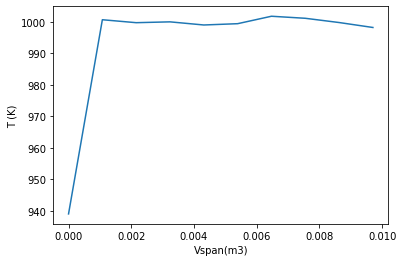

In [6]:
plt.plot(Vspan, T)
plt.xlabel('Vspan(m3)')
plt.ylabel('T (K)')
plt.show()

### Pitch calculations

In [7]:
pitch_all = 1.25*tube_Diameter*1000    # pitch in metres
print(pitch_all)

[20.   23.75 31.25 40.   47.5  62.5 ]


### Re 

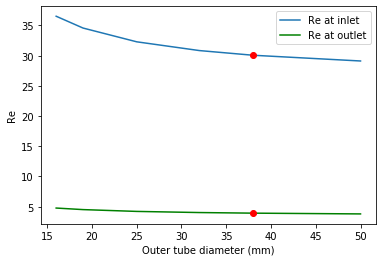

In [8]:
Re_thickness_0_inlet = np.array(Re_0_array_of_arrays)[:,0]
Re_thickness_0_outlet = np.array(Re_0_array_of_arrays)[:,-1]

Re_thickness_1_inlet = np.array(Re_1_array_of_arrays)[:,0]
Re_thickness_1_outlet = np.array(Re_1_array_of_arrays)[:,-1]

Re_thickness_2_inlet = np.array(Re_2_array_of_arrays)[:,0]
Re_thickness_2_outlet = np.array(Re_2_array_of_arrays)[:,-1]

Re_thickness_3_inlet = np.array(Re_3_array_of_arrays)[:,0]
Re_thickness_3_outlet = np.array(Re_3_array_of_arrays)[:,-1]

Re_thickness_4_inlet = np.array(Re_4_array_of_arrays)[:,0]
Re_thickness_4_outlet = np.array(Re_4_array_of_arrays)[:,-1]

plt.plot(tube_Diameter*1000, Re_thickness_0_inlet)
Re_38_inlet = Re_thickness_0_inlet[38/1000==tube_Diameter]

plt.plot(tube_Diameter*1000, Re_thickness_0_outlet, 'g')
Re_38_outlet = Re_thickness_0_outlet[38/1000==tube_Diameter]

plt.xlabel('Outer tube diameter (mm)')
plt.ylabel('Re')
plt.legend(['Re at inlet', 'Re at outlet'])
plt.plot(38, Re_38_inlet, 'or')
plt.plot(38, Re_38_outlet, 'or')
plt.show()

#plt.plot(tube_Diameter, Re_thickness_0_outlet, 'g')
# plt.plot(tube_Diameter, Re_thickness_1_outlet)
# plt.plot(tube_Diameter, Re_thickness_2_outlet)
# plt.plot(tube_Diameter, Re_thickness_3_outlet)
# plt.plot(tube_Diameter, Re_thickness_4_outlet)
# plt.xlabel('Outer tube diameter (mm)')
# plt.ylabel('Re at outlet')
# plt.legend(['t = 1.6 mm', 't = 2 mm', 't = 2.6 mm', 't = 3.2 mm'])
# plt.show()


### Pe

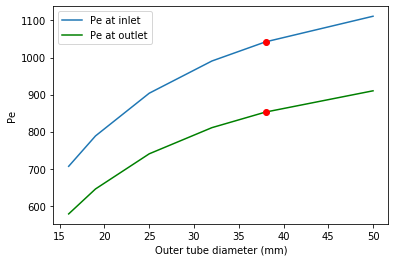

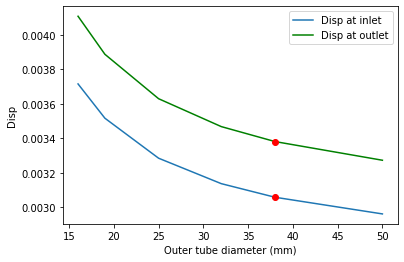

In [9]:
Pe_thickness_0_inlet = np.array(Pe_0_array_of_arrays)[:,0]
Pe_38_inlet = Pe_thickness_0_inlet[38/1000==tube_Diameter]

Pe_thickness_0_outlet = np.array(Pe_0_array_of_arrays)[:,-1]
Pe_38_outlet = Pe_thickness_0_outlet[38/1000==tube_Diameter]

plt.plot(tube_Diameter*1000, Pe_thickness_0_inlet)
plt.plot(tube_Diameter*1000, Pe_thickness_0_outlet, 'g')
plt.xlabel('Outer tube diameter (mm)')
plt.ylabel('Pe')
plt.legend(['Pe at inlet', 'Pe at outlet'])
plt.plot(38, Pe_38_inlet, 'or')
plt.plot(38, Pe_38_outlet, 'or')
plt.show()



Disp_thickness_0_inlet = np.array(Disp_0_array_of_arrays)[:,0]
Disp_38_inlet = Disp_thickness_0_inlet[38/1000==tube_Diameter]

Disp_thickness_0_outlet = np.array(Disp_0_array_of_arrays)[:,-1]
Disp_38_outlet = Disp_thickness_0_outlet[38/1000==tube_Diameter]

plt.plot(tube_Diameter*1000, Disp_thickness_0_inlet)
plt.plot(tube_Diameter*1000, Disp_thickness_0_outlet, 'g')
plt.xlabel('Outer tube diameter (mm)')
plt.ylabel('Disp')
plt.legend(['Disp at inlet', 'Disp at outlet'])
plt.plot(38, Disp_38_inlet, 'or')
plt.plot(38, Disp_38_outlet, 'or')
plt.show()

### U calculations

In [10]:
'Values specified from Investigation 2 table in report'
Do = 38/1000
t = 1.2/1000
Di = Do-2*t
Ai = np.pi/4*Di**2
Db = 2
N = 1360

'Re and Pr and Nu'
u_inlet = Q_inlet/Ai/N
Re = Di*u_inlet*ρ_inlet/μ_inlet#/(1-ϕ)
Nu = 0.023*Re**0.8*Pr**n_Nusselt
            
'U constants calcs'
hi = Nu*k/Di   # W/m2.K
print(f'hi = {hi} W/m2.K')

UiAi = 1/(1/hi/Ai + Rfi/Ai + np.log(Do/Di)/(2*np.pi*k*L) + Rfo/Ao + 1/ho/Ao)
U = UiAi/Ai

a = 4/Db
Ua = U*a

print(f'U = {U}')
print(f'Ua = {Ua}')

hi = 1884.3106230378482 W/m2.K
U = 796.1813549085568
Ua = 1592.3627098171137


#### WHSV

In [11]:
ρ_1 = 2137*(1-ϕ)                            # kg cat/m3
ρ_2 = 2154*(1-ϕ)                            # kg cat/m3
ρ_3 = 3100 *(1-ϕ)                           # kg cat/m3
V_PFR = 10                                  # m3      
m_cat_1 = ρ_1*V_PFR                          # kg cat
m_cat_2 = ρ_2*V_PFR                          # kg cat
m_cat_3 = ρ_3*V_PFR                          # kg cat

F_tot_inlet = F_eb_o + F_st_o               # kmol/s
x_st_inlet = F_st_o/F_tot_inlet    
x_eb_inlet = F_eb_o/F_tot_inlet

MM_avg_inlet = x_st_inlet*M_st + x_eb_inlet*M_eb      # kg/kmol

m_tot_inlet = F_tot_inlet*MM_avg_inlet      # kg/s
print(f'm_tot_inlet = {m_tot_inlet} kg/s')

WHSV_1 = m_tot_inlet/m_cat_1*3600                    # kg feed/kg cat.s          
print(f'WHSV_1 = {WHSV_1} kg feed/kg cat.h')

WHSV_2 = m_tot_inlet/m_cat_2*3600                    # kg feed/kg cat.s          
print(f'WHSV_2 = {WHSV_2} kg feed/kg cat.h')

WHSV_3 = m_tot_inlet/m_cat_3*3600                    # kg feed/kg cat.s          
print(f'WHSV_3 = {WHSV_3} kg feed/kg cat.h')

m_tot_inlet = 2.05703916 kg/s
WHSV_1 = 0.5775496003743565 kg feed/kg cat.h
WHSV_2 = 0.5729914094707522 kg feed/kg cat.h
WHSV_3 = 0.3981366116129032 kg feed/kg cat.h
